In [5]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [6]:
import numpy as np
import time
import os

In [7]:
USE_CUDA=torch.cuda.is_available()

In [8]:
USE_CUDA

False

##  获取字典

In [9]:
vocab_path='./vocab/vocab.txt'

In [10]:
def get_vocab(vocab_path):
    vocab_list=[]
    with open(vocab_path,'r',encoding='utf-8')as f:
        for item in f.readlines():
            vocab_list.append(item.strip())
    int_to_vocab = {idx: word for idx, word in enumerate(vocab_list)}
    vocab_to_int = {word: idx for idx, word in int_to_vocab.items()}
    return int_to_vocab,vocab_to_int

In [11]:
source_int_to_letter, source_letter_to_int=get_vocab(vocab_path)

In [12]:
len(source_int_to_letter)

50000

## Padded Batch
### return input_var, input_lengths, target_var, target_lengths

### 给添加padded 

In [13]:
def pad_sentence_batch(sentence_batch, pad_int):
    '''
    对batch中的序列进行补全，保证batch中的每行都有相同的sequence_length
    
    参数：
    - sentence batch
    - pad_int: <PAD>对应索引号
    '''
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [14]:
def get_batches(file_list,tokenize_path,batch_size,pad_int):
    '''
    定义生成器，用来获取tokenize下的所有content
    '''
    for item in file_list:
        source_path=os.path.join(tokenize_path,'content_'+item)
        target_path=os.path.join(tokenize_path,'title_'+item)
        with open(source_path,'r',encoding='utf-8')as sf:
            sources=[[int(word) for word in sentence.strip().split(' ')]for sentence in sf.readlines()]
        with open(target_path,'r',encoding='utf-8')as tf:
            targets=[[int(word) for word in sentence.strip().split(' ')]for sentence in tf.readlines()]
        
        for batch_i in range(0, len(sources)//batch_size):
            start_i = batch_i * batch_size
            sources_batch = sources[start_i:start_i + batch_size]
            targets_batch = targets[start_i:start_i + batch_size]
            # 补全序列
            pad_sources_batch = np.array(pad_sentence_batch(sources_batch, pad_int))
            pad_targets_batch = np.array(pad_sentence_batch(targets_batch, pad_int))
            
            
            # 记录每条记录的长度
            targets_lengths = []
            for target in targets_batch:
                targets_lengths.append(len(target))

            source_lengths = []
            for source in sources_batch:
                source_lengths.append(len(source))
            
            
            #做一个降序
            source_lengths=np.array(source_lengths)
            targets_lengths=np.array(targets_lengths)
            
            index=np.argsort(-source_lengths)
            source_lengths=source_lengths[index]
            targets_lengths=targets_lengths[index]
            pad_sources_batch=pad_sources_batch[index,:]
            
            pad_targets_batch=pad_targets_batch[index,:]
            
            pad_sources_batch=Variable(torch.LongTensor(pad_sources_batch)).transpose(0,1)
            pad_targets_batch=Variable(torch.LongTensor(pad_targets_batch)).transpose(0,1)

            if  USE_CUDA:
                pad_sources_batch=pad_sources_batch.cuda()
                pad_targets_batch=pad_targets_batch.cuda()
            
            
    

            #yield pad_targets_batch, pad_sources_batch, targets_lengths, source_lengths
            yield pad_sources_batch, source_lengths, pad_targets_batch, targets_lengths

## 构建模型

## Encoder

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs, hidden = self.gru(embedded, hidden)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

## Attention Decoder

### Implementing an attention module

In [13]:
# class Attn(nn.Module):
#     def __init__(self, method, hidden_size):
#         super(Attn, self).__init__()
        
#         self.method = method
#         self.hidden_size = hidden_size
        
#         if self.method == 'general':
#             self.attn = nn.Linear(self.hidden_size, hidden_size)

#         elif self.method == 'concat':
#             self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
#             self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

#     def forward(self, hidden, encoder_outputs):
#         max_len = encoder_outputs.size(0)
#         this_batch_size = encoder_outputs.size(1)

#         # Create variable to store attention energies
#         attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

#         if USE_CUDA:
#             attn_energies = attn_energies.cuda()

#         # For each batch of encoder outputs
#         for b in range(this_batch_size):
#             # Calculate energy for each encoder output
#             for i in range(max_len):
#                 attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

#         # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
#         return F.softmax(attn_energies).unsqueeze(1)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.v.dot(energy)
#             return energy

In [16]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()

        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.v = nn.Parameter(weight_init.xavier_uniform(torch.FloatTensor(1, self.hidden_size)))

    def forward(self, hidden, encoder_outputs):
        attn_energies = self.batch_score(hidden, encoder_outputs)
        return F.softmax(attn_energies).unsqueeze(1)

    def batch_score(self, hidden, encoder_outputs):
        if self.method == 'dot':
            encoder_outputs = encoder_outputs.permute(1, 2, 0)
            energy = torch.bmm(hidden.transpose(0, 1), encoder_outputs).squeeze(1)
        elif self.method == 'general':
            length = encoder_outputs.size(0)
            batch_size = encoder_outputs.size(1)
            energy = self.attn(encoder_outputs.view(-1, self.hidden_size)).view(length, batch_size, self.hidden_size)
            energy = torch.bmm(hidden.transpose(0, 1), energy.permute(1, 2, 0)).squeeze(1)
        elif self.method == 'concat':
            length = encoder_outputs.size(0)
            batch_size = encoder_outputs.size(1)
            attn_input = torch.cat((hidden.repeat(length, 1, 1), encoder_outputs), dim=2)
            energy = self.attn(attn_input.view(-1, 2 * self.hidden_size)).view(length, batch_size, self.hidden_size)
            energy = torch.bmm(self.v.repeat(batch_size, 1, 1), energy.permute(1, 2, 0)).squeeze(1)
        return energy

### Implementing the Bahdanau et al. model

In [17]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = Attn('concat', hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        # TODO: FIX BATCHING
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        context = context.transpose(0, 1) # 1 x B x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [18]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

## Testing the models

### 生成batch

In [102]:
data_path='./data_test'
file_list=os.listdir(data_path)
tokenize_path='./tokenize'
batch_size=10
pad_int=source_letter_to_int['<PAD>']

In [103]:
batcher=get_batches(file_list,tokenize_path,batch_size,pad_int)

In [104]:
input_batches, input_lengths, target_batches, target_lengths=next(batcher)


In [105]:
print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([98, 10])
target_batches torch.Size([16, 10])


In [108]:
target_batches 

Variable containing:
   824  32596    700    187    824   1749    824    390    390    824
 28625  38464    110      4    402   9371   6690     29     29     98
 15777  17980   2272      4   5926   7294   3687   1298   1298    309
 28626  17981   1633      6    131      4   2531    147    147   4907
  1070    675  23078      4  21060      4  23074   2112   2112    371
 25495   1402  32599      4    367      6  47156      3      3   3848
  8786    506   1527     69  21061      4   2532      0      0   1427
  6033      1   2414    193   2766      4   8290      0      0  32591
 14892  28627      3      5   3080    249   2144      0      0      3
 38463    599      0    880   6034  19380      3      0      0      0
     3      3      0   5427      3  14076      0      0      0      0
     0      0      0   2322      0   2031      0      0      0      0
     0      0      0   9370      0    511      0      0      0      0
     0      0      0      3      0    100      0      0      0      0

In [107]:
input_lengths

array([98, 94, 91, 87, 87, 86, 66, 59, 59, 24])

### 生成模型

In [26]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(len(source_int_to_letter), small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, len(source_int_to_letter), small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

In [27]:
print(encoder_test)
print(decoder_test)

EncoderRNN(
  (embedding): Embedding(50000, 8)
  (gru): GRU(8, 8, num_layers=2, dropout=0.1, bidirectional=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(50000, 8)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(8, 8, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=50000, bias=True)
  (attn): Attn(
    (attn): Linear(in_features=8, out_features=8, bias=True)
  )
)


### 计算Loss

In [28]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([59, 3, 8])
encoder_hidden torch.Size([4, 3, 8])


In [21]:
SOS_token=source_letter_to_int['<GO>']

In [30]:
max_target_length = max(target_lengths)

# Prepare decoder input and outputs
decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
decoder_hidden = encoder_hidden[:decoder_test.n_layers] # Use last (forward) hidden state from encoder
all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# Test masked cross entropy loss
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths
)
print('loss', loss.data[0])

loss 10.858139038085938


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\Administrator\Desktop\NLP\文本摘要\textsum\masked_cross_entropy.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_flat = functional.log_softmax(logits_flat)
C:\Users\Administrator\Desktop\NLP\文本摘要\textsum\masked_cross_entropy.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.3. Note that arange generates values in [start; end), not [start; end].
  seq_range = torch.range(0, max_len - 1).long()


In [61]:
target_batches

Variable containing:
   390    390    824
    29     29     98
  1298   1298    309
   147    147   4907
  2112   2112    371
     3      3   3848
     0      0   1427
     0      0  32591
     0      0      3
[torch.LongTensor of size 9x3]

In [32]:
step=len(target_batches)

In [86]:
loss=0
for i in range(3):
    print('1',F.cross_entropy(all_decoder_outputs[:,i,:],target_batches[:,i]))
    print('2',F.cross_entropy(all_decoder_outputs[:,i,:],target_batches[:,i],ignore_index=0))
    loss+=F.cross_entropy(all_decoder_outputs[:,i,:],target_batches[:,i],ignore_index=0)

1 Variable containing:
 10.8624
[torch.FloatTensor of size 1]

2 Variable containing:
 10.8990
[torch.FloatTensor of size 1]

1 Variable containing:
 10.8782
[torch.FloatTensor of size 1]

2 Variable containing:
 10.9051
[torch.FloatTensor of size 1]

1 Variable containing:
 10.7996
[torch.FloatTensor of size 1]

2 Variable containing:
 10.7996
[torch.FloatTensor of size 1]



In [81]:
loss/batch_size

Variable containing:
 10.8467
[torch.FloatTensor of size 1]

In [73]:
loss=0.0
for i in  range(step):
    loss+=F.cross_entropy(all_decoder_outputs[i],target_batches[i],ignore_index=0,reduce=False)

In [74]:
loss/step

Variable containing:
  7.2660
  7.2701
 10.7996
[torch.FloatTensor of size 3]

## Training with batch

In [19]:
SOS_token=source_letter_to_int['<GO>']

In [20]:
MAX_LENGTH=50

In [21]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))

    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths
    )
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

In [22]:
def train_ver2(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Run words through encoder
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    max_target_length = int(max(target_lengths))
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))
    loss=Variable(torch.FloatTensor([0]))
    # Move new Variables to CUDA
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()
        loss=loss.cuda()
    # Run through decoder one time step at a time
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # Next input is current target

    # Loss calculation and backpropagation
#     loss = masked_cross_entropy(
#         all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
#         target_batches.transpose(0, 1).contiguous(), # -> batch x seq
#         target_lengths
#     )
    
    
    for k in range(max_target_length):
        #print(F.cross_entropy(all_decoder_outputs[k],target_batches[k],ignore_index=source_letter_to_int['<PAD>']))
        loss+=F.cross_entropy(all_decoder_outputs[k],target_batches[k],ignore_index=source_letter_to_int['<PAD>'])
    loss=loss/max_target_length
    
    loss.backward()
    
    # Clip gradient norms
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

##  Running training

In [121]:
# Configure models
attn_model = 'dot'
hidden_size = 50
n_layers = 2
dropout = 0.1
batch_size = 32

# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.001
decoder_learning_ratio = 5.0
n_epochs = 200
epoch = 0
plot_every = 1
print_every = 1
evaluate_every = 1000

# Initialize models
encoder = EncoderRNN(len(source_int_to_letter), hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, len(source_int_to_letter), n_layers, dropout=dropout)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# import sconce
# job = sconce.Job('seq2seq-translate', {
#     'attn_model': attn_model,
#     'n_layers': n_layers,
#     'dropout': dropout,
#     'hidden_size': hidden_size,
#     'learning_rate': learning_rate,
#     'clip': clip,
#     'teacher_forcing_ratio': teacher_forcing_ratio,
#     'decoder_learning_ratio': decoder_learning_ratio,
# })
# job.plot_every = plot_every
# job.log_every = print_every

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [111]:
import sconce
job = sconce.Job('seq2seq-translate', {
    'attn_model': attn_model,
    'n_layers': n_layers,
    'dropout': dropout,
    'hidden_size': hidden_size,
    'learning_rate': learning_rate,
    'clip': clip,
    'teacher_forcing_ratio': teacher_forcing_ratio,
    'decoder_learning_ratio': decoder_learning_ratio,
})
job.plot_every = plot_every
job.log_every = print_every

Starting job 5aa78360021bfb51e3803113 at 2018-03-13 15:56:33


In [112]:
data_path='./data_test'
file_list=os.listdir(data_path)
tokenize_path='./tokenize'
pad_int=source_letter_to_int['<PAD>']

In [49]:
print(encoder)
print(decoder)

EncoderRNN(
  (embedding): Embedding(50000, 200)
  (gru): GRU(200, 200, num_layers=2, dropout=0.1, bidirectional=True)
)
LuongAttnDecoderRNN(
  (embedding): Embedding(50000, 200)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(200, 200, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=50000, bias=True)
  (attn): Attn(
  )
)


In [51]:
encoder.load_state_dict(torch.load('./model/encoder3.pkl'))

C:\Users\Administrator\Anaconda3\lib\site-packages\torch\serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


AttributeError: module 'torch._C' has no attribute '_cuda_getDevice'

In [114]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %fs' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [124]:
eca=0
dca=0
start=time.time()
while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    for batch_i, (input_batches, input_lengths, target_batches, target_lengths) in enumerate(
                get_batches(file_list,tokenize_path,batch_size,pad_int)):
            
        #print(input_batches)
    #input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)
        now=time.time()
        print('读取文件时间： ',as_minutes(now-start))
        start=time.time()
        #with torch.autograd.profiler.profile() as prof:
        # Run the train function
        loss, ec, dc = train_ver2(
            input_batches, input_lengths, target_batches, target_lengths,
            encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion
        )

        # Keep track of loss
        print_loss_total += loss
        plot_loss_total += loss
        eca += ec
        dca += dc

        job.record(batch_i, loss)
        #print(prof)
        now=time.time()
        print('计算返回时间： ',as_minutes(now-start))
        start=time.time()

        


读取文件时间：  0m 0.129091s


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 

## 预测

In [47]:
def load_model(encoder_path,decoder_path,flag):
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    encoder.train(flag)
    decoder.train(flag)
    return encoder,decoder
    

In [122]:
encoder,decoder=load_model('./model/encoder5.pkl','./model/decoder5.pkl',False)

In [37]:
def source_to_seq(text):
    '''
    对源数据进行转换
    '''
    sequence_length = 120
    seq=[source_letter_to_int.get(word, source_letter_to_int['<UNK>']) for word in text.split(' ')] + [source_letter_to_int['<PAD>']]*(sequence_length-len(text))
    seq=Variable(torch.LongTensor(seq))
    return seq.unsqueeze(0).transpose(0,1)


In [137]:
text='''
郝海东 职业化 后 遭遇 重罚 第一 人   DATE   的 曼谷 亚运会 上 郝海东 在 比赛 中 不 服从 裁判 并 向 一名 边裁 吐口 水 亚足联 当时 就 对 他 禁赛   NUMBER   场 后来 又 追加 处罚 被 禁赛   DATE   这是 迄今为止 国脚 遭到 的 最 严厉 的 处罚 郝海东 的 这次 被 禁赛 的 范围 非常 广 这 其中 也 包括 了 国内 的 联赛 等 国内外 的 一切 正式 比赛 所幸 郝海东 本身 就是 个 天才 并 没有 因
 '''

In [112]:
def evaluate(sentence, max_length=120):
    EOS_token=source_letter_to_int['<EOS>']
    #input  output
    input_variable = source_to_seq(text)
    input_length = [input_variable.size()[0]]
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    encoder_hidden = Variable(torch.zeros(n_layers*2, 1, hidden_size))

    if USE_CUDA:
        input_variable=input_variable.cuda()
        decoder_input=decoder_input.cuda()
        encoder_hidden=encoder_hidden.cuda()
    
    # Run through encoder
    #encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable,input_length, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_hidden = encoder_hidden[:n_layers]
    
    
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        
        #print(decoder_attentions[di,:decoder_attention.size(2)])
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(source_int_to_letter[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [138]:
word,att=evaluate("text")

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [139]:
print(' '.join(word))

鸟巢 十大 事件 中 事件 国奥 一战 成名 多 成名 最 恶劣 <EOS>


In [ ]:
s.join

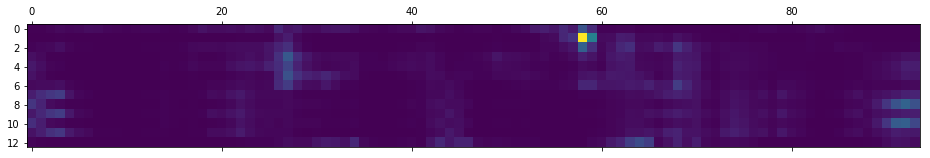

In [140]:
#output_words, attentions = evaluate("je suis trop froid .")
plt.matshow(att.numpy())